# Import libraries

In [1]:
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

2025-09-05 04:38:18.973411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)
!python -V

2.13.1
Python 3.11.0


In [3]:
tf_text.__version__

'2.13.0-rc0'

# Example 1: Predict the tag for a Stack Overflow question

## Download and explore the dataset

In [4]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(
    fname='stack_overflow',
    origin=data_url,
    untar=True,
    cache_dir='.',
    cache_subdir='')

In [5]:
dataset_dir

'./stack_overflow'

In [6]:
import os
os.listdir(dataset_dir)

['test', 'README.md', 'train']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [8]:
sample_file = os.path.join(train_dir, 'python/1755.txt')

with open(sample_file) as f:
  print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



## Load the Dataset

In [9]:
batch_size = 32
seed = 42

raw_train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(4):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

In [11]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [12]:
# Create a validation set.
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [13]:
test_dir = os.path.join(dataset_dir, 'test')

# Create a test set.
raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


## Configure the datasets for performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Prepare the dataset for training

In [15]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='multi_hot')

In [16]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

In [17]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [18]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int32)


'binary' vectorized question:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0

(0.0, 1000.0)

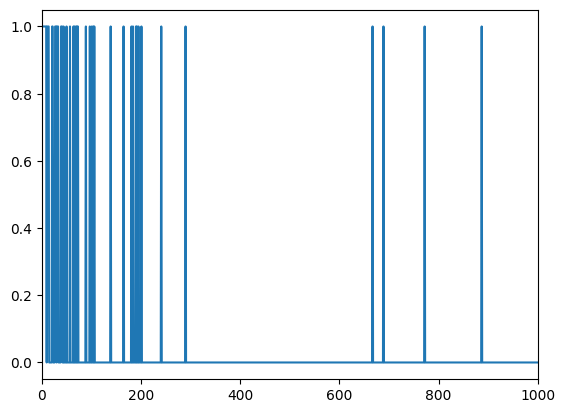

In [19]:
print("'binary' vectorized question:\n", list(binary_vectorize_layer(first_question).numpy()))

plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0, 1000)

In [20]:
print("'int' vectorized question:\n", int_vectorize_layer(first_question).numpy())

'int' vectorized question:
 [1011  773    9 2456    8 1863 2362  690 1267    4   40    5    1 1011
  196   12   74   13   72   33    2   98  105   14    3   70 9611    3
   34  888  202  773  107    8   41  242   40   58  291   90    3  196
  191   10    2  182    6  668    6   13   30 1187   12  773   22   42
    1   28    5  140   29 5213   15   29    1   28   51    1    1    1
    7   23   30    3  291   10   67    6   32   65  185  166  102   14
    2   65    6    1  193    9 2784   45 2410    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    

In [21]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  roman
313 --->  source
Vocabulary size: 10000


## Train the Model

In [22]:
binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [23]:
bin_history = binary_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10
200/200 [==============================] - 2s 5ms/step - loss: 1.1223 - accuracy: 0.6400 - val_loss: 0.9172 - val_accuracy: 0.7763
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.7811 - accuracy: 0.8153 - val_loss: 0.7526 - val_accuracy: 0.8025
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6290 - accuracy: 0.8587 - val_loss: 0.6666 - val_accuracy: 0.8106
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.5351 - accuracy: 0.8870 - val_loss: 0.6129 - val_accuracy: 0.8213
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4688 - accuracy: 0.9033 - val_loss: 0.5761 - val_accuracy: 0.8288
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4184 - accuracy: 0.9169 - val_loss: 0.5493 - val_accuracy: 0.8338
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3780 - accuracy: 0.9295 - val_loss: 0.5290 - val_accuracy: 0.8356
Epoch 

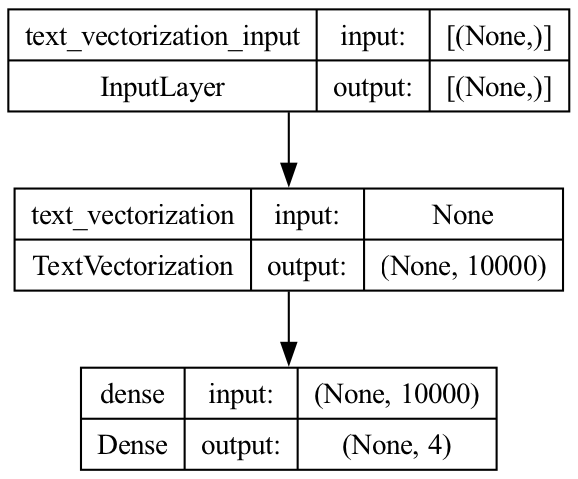

In [24]:
tf.keras.utils.plot_model(binary_model, show_shapes=True, dpi=150)

In [25]:
def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers =[]
  if vectorizer is not None:
    my_layers = [vectorizer]

  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Dropout(0.5),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])

  model = tf.keras.Sequential(my_layers)
  return model

In [26]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4, vectorizer=int_vectorize_layer)

In [27]:
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

int_history = int_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=10)

Epoch 1/10
200/200 [==============================] - 5s 24ms/step - loss: 1.2817 - accuracy: 0.4083 - val_loss: 0.9798 - val_accuracy: 0.6012
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.8068 - accuracy: 0.6623 - val_loss: 0.6553 - val_accuracy: 0.7312
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.5873 - accuracy: 0.7705 - val_loss: 0.5573 - val_accuracy: 0.7875
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.4309 - accuracy: 0.8453 - val_loss: 0.4922 - val_accuracy: 0.8188
Epoch 5/10
200/200 [==============================] - 5s 25ms/step - loss: 0.3125 - accuracy: 0.9003 - val_loss: 0.4792 - val_accuracy: 0.8225
Epoch 6/10
200/200 [==============================] - 5s 23ms/step - loss: 0.2247 - accuracy: 0.9372 - val_loss: 0.4962 - val_accuracy: 0.8238
Epoch 7/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1626 - accuracy: 0.9577 - val_loss: 0.5175 - val_accuracy: 0.8256

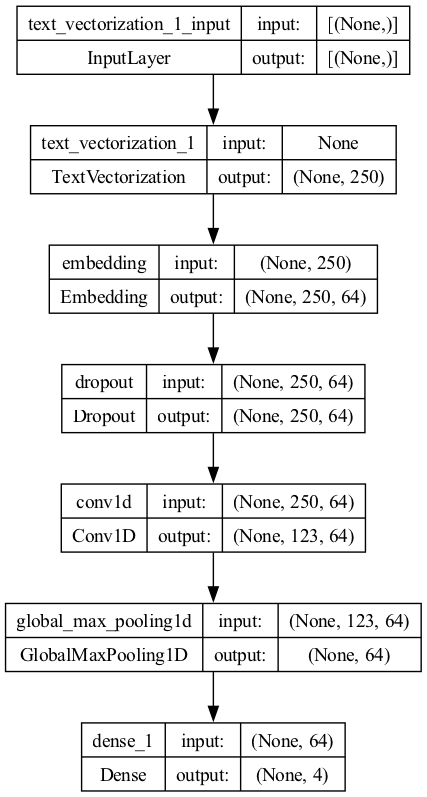

In [28]:
tf.keras.utils.plot_model(int_model, show_shapes=True, dpi=100)

Text(0, 0.5, 'CE/token')

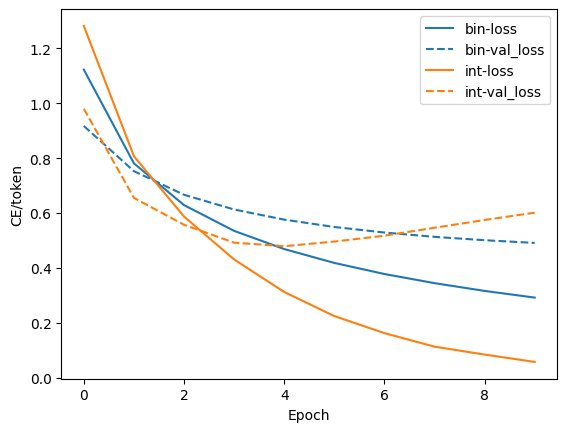

In [29]:
loss = plt.plot(bin_history.epoch, bin_history.history['loss'], label='bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color=loss[0].get_color(), label='bin-val_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')

## Inference

In [30]:
examples = tf.constant(['How do you sort a list?'])
binary_model.predict(examples)

1/1 [==============================] - 0s 143ms/step


array([[-0.11921982,  0.01662744, -0.6319592 ,  0.37563875]],
      dtype=float32)

# Example 2: Predict the author of Iliad translations


In [31]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = utils.get_file(name, origin=DIRECTORY_URL + name, cache_dir='.')

parent_dir = pathlib.Path(text_dir).parent
parent_dir


PosixPath('datasets')

In [32]:
list(parent_dir.iterdir())

[PosixPath('datasets/cowper.txt'),
 PosixPath('datasets/butler.txt'),
 PosixPath('datasets/derby.txt')]

In [33]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64)

In [34]:
labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(str(parent_dir/file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

In [35]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

In [36]:
all_labeled_data = labeled_data_sets[0]

for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)

In [37]:
for text, label in all_labeled_data.take(10):
  print("Sentence: ", text.numpy())
  print("Label:", label.numpy())

Sentence:  b'And over all their glittering helmets Jove'
Label: 0
Sentence:  b"Arm'd as he was, he leap'd upon the plain."
Label: 1
Sentence:  b"But loudly Hector on his kinsmen call'd;"
Label: 1
Sentence:  b'god. They washed their hands and took up the barley-meal to sprinkle'
Label: 2
Sentence:  b"To make me downy-cheek'd as in my youth;"
Label: 0
Sentence:  b'wall--but he did not join the Achaeans for he heeded the charge which'
Label: 2
Sentence:  b'sea are stationed on the lowermost spurs of many-fountained Ida, and I'
Label: 2
Sentence:  b'Those tresses bright, with gold and silver bound,'
Label: 1
Sentence:  b"Apollo, son of Jove, the chief address'd:"
Label: 1
Sentence:  b'down from his chariot; so he fell in the dust and clutched the earth in'
Label: 2


In [38]:
class MyTokenizer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.tokenizer = tf_text.UnicodeScriptTokenizer()

  def call(self, text):
    lower_case = tf_text.case_fold_utf8(text)
    result = self.tokenizer.tokenize(lower_case)
    # If you pass a batch of strings, it will return a RaggedTensor.
    if isinstance(result, tf.RaggedTensor):
      # Convert to dense 0-padded.
      result = result.to_tensor()
    return result

In [39]:
tokenizer = MyTokenizer()

In [40]:
tokenized_ds = all_labeled_data.map(lambda text, label: (tokenizer(text), label))
tokenized_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [41]:
for tokens, label in tokenized_ds.take(3):
  print(tokens)
  print(label)
  print()

tf.Tensor([b'and' b'over' b'all' b'their' b'glittering' b'helmets' b'jove'], shape=(7,), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)

tf.Tensor(
[b'arm' b"'" b'd' b'as' b'he' b'was' b',' b'he' b'leap' b"'" b'd' b'upon'
 b'the' b'plain' b'.'], shape=(15,), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)

tf.Tensor([b'but' b'loudly' b'hector' b'on' b'his' b'kinsmen' b'call' b"'" b'd' b';'], shape=(10,), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)



In [42]:
AUTOTUNE = tf.data.AUTOTUNE
tokenized_ds = tokenized_ds.cache().prefetch(tf.data.AUTOTUNE)

vocab_count = collections.Counter()
for toks, labels in tokenized_ds.ragged_batch(1000):
  toks = tf.reshape(toks, [-1])
  for tok in toks.numpy():
    vocab_count[tok] += 1

vocab = [tok for tok, count in vocab_count.most_common(VOCAB_SIZE)]

print("First five vocab entries:", vocab[:5])
print()

First five vocab entries: [b',', b'the', b'and', b"'", b'of']



In [43]:
class MyVocabTable(tf.keras.layers.Layer):
  def __init__(self, vocab):
    super().__init__()
    self.keys = [''] + vocab
    self.values = range(len(self.keys))

    self.init = tf.lookup.KeyValueTensorInitializer(
        self.keys, self.values, key_dtype=tf.string, value_dtype=tf.int64)

    num_oov_buckets = 1

    self.table = tf.lookup.StaticVocabularyTable(self.init, num_oov_buckets)

  def call(self, x):
    result = self.table.lookup(x)
    return result

In [44]:
vocab_table = MyVocabTable(['a','b','c'])
vocab_table(tf.constant([''] + list('abcdefghi')))

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 2, 3, 4, 4, 4, 4, 4, 4])>

In [45]:
vocab_table = MyVocabTable(vocab)

In [46]:
preprocess_text = tf.keras.Sequential([
    tokenizer,
    vocab_table
])

In [47]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())

vectorized_text = preprocess_text(example_text)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'And over all their glittering helmets Jove'
Vectorized sentence:  [   3  190   23   29 1330 2174   52]


In [48]:
all_encoded_data = all_labeled_data.map(lambda text, labels:(preprocess_text(text), labels))

for ids, label in all_encoded_data.take(1):
  break

print("Ids: ", ids.numpy())
print("Label: ", label.numpy())

Ids:  [   3  190   23   29 1330 2174   52]
Label:  0


In [49]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE).padded_batch(BATCH_SIZE)

In [50]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (64, 16)
Label batch shape:  (64,)
First text example:  tf.Tensor(
[   3  190   23   29 1330 2174   52    0    0    0    0    0    0    0
    0    0], shape=(16,), dtype=int64)
First label example:  tf.Tensor(0, shape=(), dtype=int64)


In [51]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

## Train the Model

In [52]:
model = create_model(vocab_size=VOCAB_SIZE+2, num_labels=3)

model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [53]:
history = model.fit(train_data, validation_data=validation_data, epochs=3)

Epoch 1/3


2025-09-05 04:40:10.364746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 11118 of 50000
2025-09-05 04:40:20.364140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 29609 of 50000


     27/Unknown - 29s 6ms/step - loss: 1.0526 - accuracy: 0.4167

2025-09-05 04:40:28.714107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


697/697 [==============================] - 39s 14ms/step - loss: 0.5768 - accuracy: 0.7384 - val_loss: 0.4019 - val_accuracy: 0.8292
Epoch 2/3


2025-09-05 04:40:48.594728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 9865 of 50000
2025-09-05 04:40:58.594655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 25823 of 50000
2025-09-05 04:41:08.594822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 43532 of 50000


 24/697 [>.............................] - ETA: 4s - loss: 0.3773 - accuracy: 0.8431 

2025-09-05 04:41:09.151022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


697/697 [==============================] - 40s 13ms/step - loss: 0.3611 - accuracy: 0.8513 - val_loss: 0.3578 - val_accuracy: 0.8400
Epoch 3/3


2025-09-05 04:41:28.231078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 11792 of 50000
2025-09-05 04:41:38.305079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 30745 of 50000


 25/697 [>.............................] - ETA: 4s - loss: 0.2707 - accuracy: 0.8988 

2025-09-05 04:41:45.802890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


697/697 [==============================] - 37s 13ms/step - loss: 0.2899 - accuracy: 0.8842 - val_loss: 0.3501 - val_accuracy: 0.8486


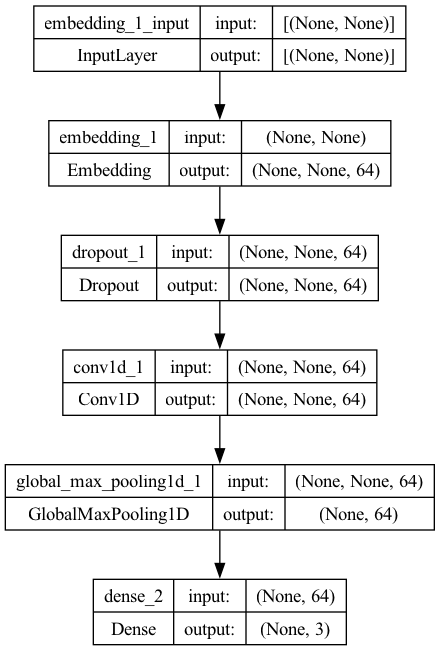

In [54]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [55]:
metrics = model.evaluate(validation_data, return_dict=True)

print("Loss: ", metrics['loss'])
print("Accuracy: {:2.2%}".format(metrics['accuracy']))

79/79 [==============================] - 5s 38ms/step - loss: 0.3501 - accuracy: 0.8486
Loss:  0.3500705063343048
Accuracy: 84.86%


## Export the model

In [56]:
export_model = tf.keras.Sequential([
    preprocess_text,
    model
])

In [57]:
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [58]:
# Create a test dataset of raw strings.
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [59]:
loss, accuracy = export_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 [==============================] - 6s 10ms/step - loss: 0.6924 - accuracy: 0.8486
Loss:  0.6924125552177429
Accuracy: 84.86%


In [60]:
export_model(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

array([[-2.8735638 , -0.34105808,  4.0480957 ]], dtype=float32)

## Run Inference on new data

In [61]:
inputs = [
    "Join'd to th' Ionians with their flowing robes,",  # Label: 1
    "the allies, and his armour flashed about him so that he seemed to all",  # Label: 2
    "And with loud clangor of his arms he fell.",  # Label: 0
]

predicted_scores = export_model.predict(inputs)
predicted_labels = tf.math.argmax(predicted_scores, axis=1)

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

1/1 [==============================] - 4s 4s/step
Question:  Join'd to th' Ionians with their flowing robes,
Predicted label:  1
Question:  the allies, and his armour flashed about him so that he seemed to all
Predicted label:  2
Question:  And with loud clangor of his arms he fell.
Predicted label:  0


# Example 3: Download more datasets using TensorFlow Datasets (TFDS)
 - We will download the IMDB Large Movie Review dataset to train a model for sentiment classification.

In [62]:
# Training set.
train_ds = tfds.load(
    'imdb_reviews',
    data_dir = '.',
    split='train[:80%]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

In [63]:
# Validation set.
val_ds = tfds.load(
    'imdb_reviews',
    split='train[80%:]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

In [64]:
for review_batch, label_batch in val_ds.take(1):
  for i in range(5):
    print("Review: ", review_batch[i].numpy())
    print("Label: ", label_batch[i].numpy())

Review:  b"Instead, go to the zoo, buy some peanuts and feed 'em to the monkeys. Monkeys are funny. People with amnesia who don't say much, just sit there with vacant eyes are not all that funny.<br /><br />Black comedy? There isn't a black person in it, and there isn't one funny thing in it either.<br /><br />Walmart buys these things up somehow and puts them on their dollar rack. It's labeled Unrated. I think they took out the topless scene. They may have taken out other stuff too, who knows? All we know is that whatever they took out, isn't there any more.<br /><br />The acting seemed OK to me. There's a lot of unfathomables tho. It's supposed to be a city? It's supposed to be a big lake? If it's so hot in the church people are fanning themselves, why are they all wearing coats?"
Label:  0
Review:  b'Well, was Morgan Freeman any more unusual as God than George Burns? This film sure was better than that bore, "Oh, God". I was totally engrossed and LMAO all the way through. Carrey was

2025-09-05 04:42:11.782020: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Prepare the dataset for training

In [65]:
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [66]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [67]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)

In [68]:
# Configure datasets for performance as before.
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [69]:
model = create_model(vocab_size=VOCAB_SIZE, num_labels=1)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          20544     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 660609 (2.52 MB)
Trainable params: 660609 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [70]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [71]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
313/313 [==============================] - 13s 40ms/step - loss: 0.5926 - accuracy: 0.6222 - val_loss: 0.4312 - val_accuracy: 0.7982
Epoch 2/3
313/313 [==============================] - 11s 35ms/step - loss: 0.3728 - accuracy: 0.8299 - val_loss: 0.3457 - val_accuracy: 0.8502
Epoch 3/3
313/313 [==============================] - 13s 40ms/step - loss: 0.2815 - accuracy: 0.8795 - val_loss: 0.3247 - val_accuracy: 0.8540


In [72]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 [==============================] - 0s 3ms/step - loss: 0.3247 - accuracy: 0.8540
Loss:  0.32467120885849
Accuracy: 85.40%


## Export the model

In [73]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [74]:
# 0 --> negative review
# 1 --> positive review
inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
]

predicted_scores = export_model.predict(inputs)
predicted_labels = [int(round(x[0])) for x in predicted_scores]

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label)

1/1 [==============================] - 0s 108ms/step
Question:  This is a fantastic movie.
Predicted label:  1
Question:  This is a bad movie.
Predicted label:  0
Question:  This movie was so bad that it was good.
Predicted label:  0
Question:  I will never say yes to watching this movie.
Predicted label:  0
